# Wind Power Forecasting

## Introduction
In this project, we conducted a time series analysis aimed at forecasting wind energy generation from a specific turbine over the next 15 days. Accurate forecasting of wind energy production is essential to optimize the operation of wind farms and ensure a reliable supply of renewable energy.

## Table of Contents
1. [Package Installation](#package-installation)
2. [Library Imports](#library-imports)
3. [Data Loading](#data-loading)
4. [Initial Data Exploration](#initial-data-exploration)
5. [Data Preparation, Visualization, and Correlation Analysis](#data-prep-visu-corr)
6. [Modeling](#modeling)
7. [Model Evaluation](#model-evaluation)
8.  [Conclusion and Next Steps](#conclusion-and-next-steps)

## Package Installation <a name="package-installation"></a>
In this cell, we will install the necessary Python packages required for our data analysis project. This step ensures that all the libraries needed for data manipulation, visualization, and machine learning are available in our environment. 

We will use the `pip` command to install the following libraries:

- **NumPy**: A library for numerical computations and handling arrays.
- **Pandas**: A powerful data manipulation and analysis library, particularly useful for working with structured data.
- **Matplotlib**: A plotting library for creating static, animated, and interactive visualizations in Python.
- **Seaborn**: A statistical data visualization library based on Matplotlib that provides a high-level interface for drawing attractive graphics.
- **Scikit-learn**: A machine learning library that provides simple and efficient tools for data mining and data analysis.

In [1]:
# List of required libraries
required_libraries = [
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'pmdarima'
]

def install(package):
    """Install the package using pip in a Jupyter Notebook."""
    print(f"Installing {package}...")
    # Use the Jupyter magic command for installation
    get_ipython().system(f'pip install {package}')

def check_libraries(libraries):
    """Check if the libraries are installed and install them if necessary."""
    missing_libraries = []

    for library in libraries:
        try:
            __import__(library)
        except ImportError:
            missing_libraries.append(library)
        except Exception as e:
            # Captures other errors that may occur during import
            print(f"Error importing {library}: {e}")
            missing_libraries.append(library)

    if missing_libraries:
        print(f"The following libraries are missing: {', '.join(missing_libraries)}")
        print("Starting installation...")

        installation_success = True  # Flag to track installation success

        for library in missing_libraries:
            try:
                install(library)
                print(f"{library} installed successfully.")
            except Exception as e:
                print(f"Failed to install {library}: {e}")
                installation_success = False  # Mark as failed if there was an error

        # Check again if the libraries were installed
        for library in missing_libraries:
            try:
                __import__(library)
            except ImportError:
                print(f"Error: {library} was not installed correctly.")
                installation_success = False  # Mark as failed if still missing

        # Final message based on installation success
        if installation_success:
            print("All libraries were installed successfully.")
        else:
            print("Some libraries were not installed correctly.")
    else:
        print("All libraries are already installed.")

if __name__ == "__main__":
    check_libraries(required_libraries)

The following libraries are missing: scikit-learn, pmdarima
Starting installation...
Installing scikit-learn...
scikit-learn installed successfully.
Installing pmdarima...
pmdarima installed successfully.
Error: scikit-learn was not installed correctly.
Error: pmdarima was not installed correctly.
Some libraries were not installed correctly.


## Library Imports <a name="library-imports"></a>
In this cell, we will import all the necessary libraries that we will use throughout the analysis. This includes libraries for data manipulation, visualization, and machine learning.

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima


## Data Loading <a name="data-loading"></a>
In this section, we will load the dataset containing information about wind energy generation and related factors. This dataset includes weather conditions, turbine specifications, and historical energy production data. We will examine the structure of the data and check for any initial issues, such as missing values or inconsistencies, to ensure the integrity of our analysis.

In [177]:
warnings.filterwarnings('ignore')

# Paths to the CSV files
df_path = '../data/Turbine_Data.csv'

# Reading the CSV files
df = pd.read_csv(df_path)

In [178]:
# Rename the column 'Unnamed: 0' to 'Time'
df.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)

# Summary statistics for numerical columns
print("Wind Power Data:")
print(df.describe())

Wind Power Data:
        ActivePower  AmbientTemperatue  BearingShaftTemperature  \
count  94750.000000       93817.000000             62518.000000   
mean     619.109805          28.774654                43.010189   
std      611.275373           4.369145                 5.545312   
min      -38.524659           0.000000                 0.000000   
25%       79.642258          25.627428                39.840247   
50%      402.654893          28.340541                42.910877   
75%     1074.591780          31.664772                47.007976   
max     1779.032433          42.405597                55.088655   

       Blade1PitchAngle  Blade2PitchAngle  Blade3PitchAngle  \
count      41996.000000      41891.000000      41891.000000   
mean           9.749641         10.036535         10.036535   
std           20.644828         20.270465         20.270465   
min          -43.156734        -26.443415        -26.443415   
25%           -0.939849         -0.433264         -0.433264   
5

In [179]:
# Using shape to check the dimensions of the DataFrame
print("\nShape of Combined Data:", df.shape)


Shape of Combined Data: (118224, 22)


## Initial Data Exploration <a name="initial-data-exploration"></a>
In this section, we will perform an exploratory data analysis (EDA) to understand the dataset better. We will look at the data types, summary statistics, and any missing values, which will help us determine the next steps for cleaning and preparing the data.

In [180]:
# Assuming 'df' is your DataFrame
# Remove the 'ControlBoxTemperature' and 'WTG' columns from the DataFrame because
# 'ControlBoxTemperature' contains a high proportion of missing/zero values and low variability,
# which do not provide any useful information for analysis.
df.drop(columns=['ControlBoxTemperature', 'WTG'], inplace=True)


# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 Time                                0
ActivePower                     23474
AmbientTemperatue               24407
BearingShaftTemperature         55706
Blade1PitchAngle                76228
Blade2PitchAngle                76333
Blade3PitchAngle                76333
GearboxBearingTemperature       55684
GearboxOilTemperature           55786
GeneratorRPM                    55929
GeneratorWinding1Temperature    55797
GeneratorWinding2Temperature    55775
HubTemperature                  55818
MainBoxTemperature              55717
NacellePosition                 45946
ReactivePower                   23476
RotorRPM                        56097
TurbineStatus                   55316
WindDirection                   45946
WindSpeed                       23629
dtype: int64


In our analysis, we will begin by removing any observations that do not contain values in any of the features. This step is crucial for cleaning the dataset and ensuring that we are working with relevant data points. Following this initial cleanup, we will individually analyze the remaining variables to identify and address any missing values.

In [181]:
# Remove observations where all features are NaN, 
# except for the 'Time' column. 
# We do this by filtering the DataFrame.
# We check if the sum of NaN values across all columns (excluding 'Time') is equal to the number of columns.
# If true, it means that all those features are NaN.
df_cleaned = df[df.drop(columns='Time').notna().sum(axis=1) > 0]

# Displaying the cleaned DataFrame to check the result
print("Cleaned DataFrame:\n", df_cleaned)

# Optionally, we can check the new shape of the DataFrame to see how many rows were removed
print("Original DataFrame Shape:", df.shape)
print("Cleaned DataFrame Shape:", df_cleaned.shape)

Cleaned DataFrame:
                              Time  ActivePower  AmbientTemperatue  \
144     2018-01-01 00:00:00+00:00    -5.357727          23.148729   
145     2018-01-01 00:10:00+00:00    -5.822360          23.039754   
146     2018-01-01 00:20:00+00:00    -5.279409          22.948703   
147     2018-01-01 00:30:00+00:00    -4.648054          22.966851   
148     2018-01-01 00:40:00+00:00    -4.684632          22.936520   
...                           ...          ...                ...   
118219  2020-03-30 23:10:00+00:00    70.044465          27.523741   
118220  2020-03-30 23:20:00+00:00    40.833474          27.602882   
118221  2020-03-30 23:30:00+00:00    20.777790          27.560925   
118222  2020-03-30 23:40:00+00:00    62.091039          27.810472   
118223  2020-03-30 23:50:00+00:00    68.664425          27.915828   

        BearingShaftTemperature  Blade1PitchAngle  Blade2PitchAngle  \
144                         NaN               NaN               NaN   
145      

In [182]:
# Check again the missing values
missing_values = df_cleaned.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 Time                                0
ActivePower                       740
AmbientTemperatue                1673
BearingShaftTemperature         32972
Blade1PitchAngle                53494
Blade2PitchAngle                53599
Blade3PitchAngle                53599
GearboxBearingTemperature       32950
GearboxOilTemperature           33052
GeneratorRPM                    33195
GeneratorWinding1Temperature    33063
GeneratorWinding2Temperature    33041
HubTemperature                  33084
MainBoxTemperature              32983
NacellePosition                 23212
ReactivePower                     742
RotorRPM                        33363
TurbineStatus                   32582
WindDirection                   23212
WindSpeed                         895
dtype: int64


In the next step, we will conduct a visual analysis of the missing values to better understand the distribution and patterns of this data. This will help us determine the best approach for handling the missing values.

## Data Preparation, Visualization, and Correlation Analysis <a name="data-prep-visu-corr"></a>
Data visualization is key to understanding trends and patterns in our data. In this session we will assess the correlation of each variable with our target variable, "ActivePower." This analysis will guide us in determining which variables are most relevant for imputation. Finally, we will apply appropriate techniques to fill in the missing values for these selected variables, ensuring that our dataset is both complete and ready for further analysis.

Correlation Matrix:
                               ActivePower  AmbientTemperatue  \
ActivePower                      1.000000          -0.065637   
AmbientTemperatue               -0.065637           1.000000   
BearingShaftTemperature          0.655400           0.246505   
Blade1PitchAngle                -0.368997           0.085461   
Blade2PitchAngle                -0.367978           0.090904   
Blade3PitchAngle                -0.367978           0.090904   
GearboxBearingTemperature        0.818850           0.017216   
GearboxOilTemperature            0.821921           0.162511   
GeneratorRPM                     0.849604          -0.130123   
GeneratorWinding1Temperature     0.931390           0.077859   
GeneratorWinding2Temperature     0.932521           0.078736   
HubTemperature                   0.347363           0.589729   
MainBoxTemperature               0.101627           0.836539   
NacellePosition                  0.028108          -0.037498   
ReactivePower      

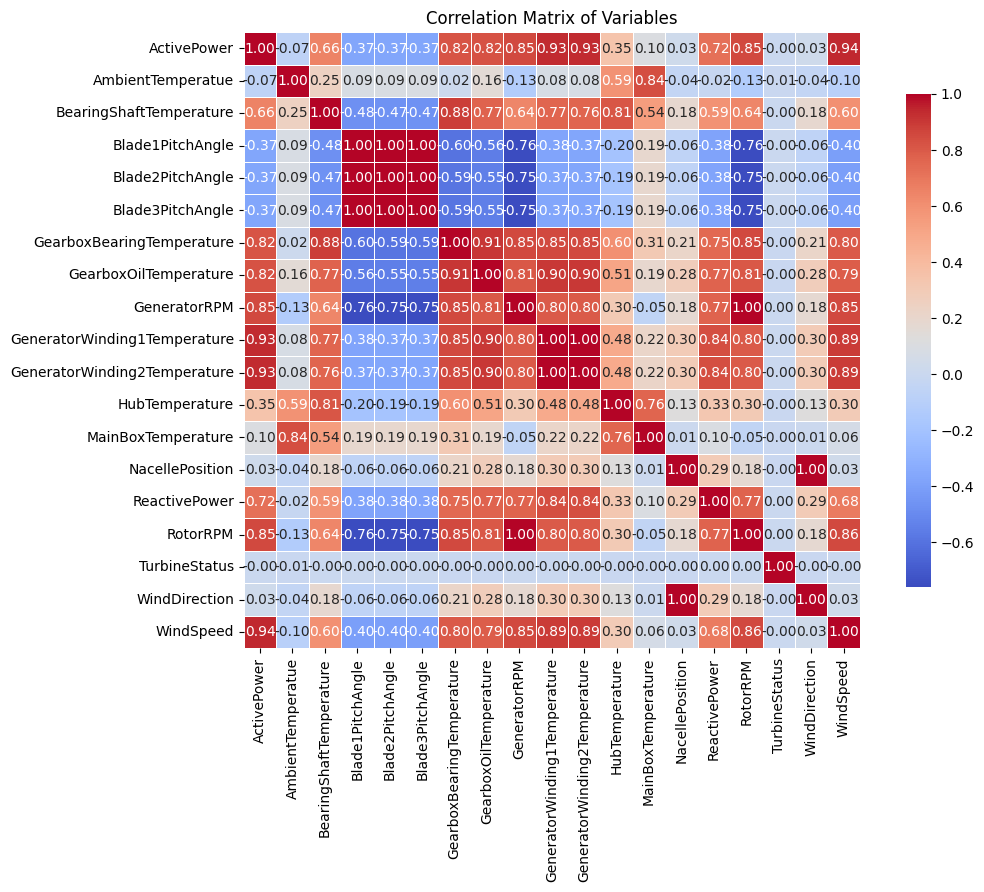

In [183]:
# Calculate the correlation matrix
# This method computes the pairwise correlation of columns, excluding NA/null values.
correlation_matrix = df_cleaned.drop(columns='Time').corr()

# Display the correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Set up the matplotlib figure
# This line sets the size of the figure for better visibility.
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize the correlation matrix
# 'annot=True' will display the correlation coefficients on the heatmap.
# 'cmap' specifies the color map, and 'fmt' is used to format the annotation text.
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

# Set the title of the plot
plt.title('Correlation Matrix of Variables')

# Show the plot
plt.show()

Removing highly correlated variables is crucial because redundancy can lead to overfitting, making the model less generalizable to unseen data. By eliminating these variables, we reduce noise and improve the model's predictive performance.

In [184]:
# Display the original shape of the DataFrame
print("Original DataFrame Shape:", df_cleaned.shape)

# Remove one of the Generator Winding Temperatures
# These two variables are almost identical, with a correlation of 0.999959.
# We will remove 'GeneratorWinding2Temperature' to reduce redundancy.
df_cleaned.drop(columns='GeneratorWinding2Temperature', inplace=True)
print("Removed 'GeneratorWinding2Temperature' due to high correlation with 'GeneratorWinding1Temperature'.")

# Remove one of the Gearbox Temperatures
# The correlation between these two variables is 0.906020.
# We will remove 'GearboxBearingTemperature'.
df_cleaned.drop(columns='GearboxBearingTemperature', inplace=True)
print("Removed 'GearboxBearingTemperature' due to high correlation with 'GearboxOilTemperature'.")

# Remove one of the RPM variables
# 'GeneratorRPM' and 'RotorRPM' have a correlation of 0.999723.
# We will remove 'RotorRPM'.
df_cleaned.drop(columns='RotorRPM', inplace=True)
print("Removed 'RotorRPM' due to high correlation with 'GeneratorRPM'.")

# Remove two of the Pitch Angles
# The pitch angles are highly correlated with each other.
# We'll keep 'Blade1PitchAngle' and remove the other two.
df_cleaned.drop(columns=['Blade2PitchAngle', 'Blade3PitchAngle'], inplace=True)
print("Removed 'Blade2PitchAngle' and 'Blade3PitchAngle' due to high correlation with 'Blade1PitchAngle'.")

# Display the new shape of the DataFrame
print("New DataFrame Shape:", df_cleaned.shape)

# Optional: Display the remaining columns for verification
print("Remaining Columns:\n", df_cleaned.columns)

Original DataFrame Shape: (95490, 20)
Removed 'GeneratorWinding2Temperature' due to high correlation with 'GeneratorWinding1Temperature'.
Removed 'GearboxBearingTemperature' due to high correlation with 'GearboxOilTemperature'.
Removed 'RotorRPM' due to high correlation with 'GeneratorRPM'.
Removed 'Blade2PitchAngle' and 'Blade3PitchAngle' due to high correlation with 'Blade1PitchAngle'.
New DataFrame Shape: (95490, 15)
Remaining Columns:
 Index(['Time', 'ActivePower', 'AmbientTemperatue', 'BearingShaftTemperature',
       'Blade1PitchAngle', 'GearboxOilTemperature', 'GeneratorRPM',
       'GeneratorWinding1Temperature', 'HubTemperature', 'MainBoxTemperature',
       'NacellePosition', 'ReactivePower', 'TurbineStatus', 'WindDirection',
       'WindSpeed'],
      dtype='object')


We will remove variables with low correlation to the target variable 'ActivePower'. This step is important because including variables that do not contribute meaningfully to the prediction can introduce noise and reduce the overall performance of the model. 

By focusing on variables that have a stronger relationship with 'ActivePower', we aim to enhance the model's predictive capability.

In [185]:
# Calculate the correlation matrix for the DataFrame, dropping the 'Time' column
correlation_matrix = df_cleaned.drop(columns=['Time']).corr()

# Define the correlation limit
correlation_limit = 0.3  # Set the threshold for low correlation

# Identify variables with low correlation with 'ActivePower'
# We select variables where the absolute correlation with 'ActivePower' is less than the defined limit
low_correlation_vars = correlation_matrix[correlation_matrix['ActivePower'].abs() < correlation_limit].index.tolist()

# Remove 'ActivePower' from the list to avoid dropping it
if 'ActivePower' in low_correlation_vars:
    low_correlation_vars.remove('ActivePower')  # Ensure we don't remove the target variable itself

# Remove the variables with low correlation from the DataFrame
df_cleaned.drop(columns=low_correlation_vars, inplace=True)  # Drop the identified low-correlation variables

# Display the remaining columns in the DataFrame
print("Remaining columns after removing variables with low correlation:")
print(df_cleaned.columns)  # Print the columns that are left in the DataFrame

Remaining columns after removing variables with low correlation:
Index(['Time', 'ActivePower', 'BearingShaftTemperature', 'Blade1PitchAngle',
       'GearboxOilTemperature', 'GeneratorRPM', 'GeneratorWinding1Temperature',
       'HubTemperature', 'ReactivePower', 'WindSpeed'],
      dtype='object')


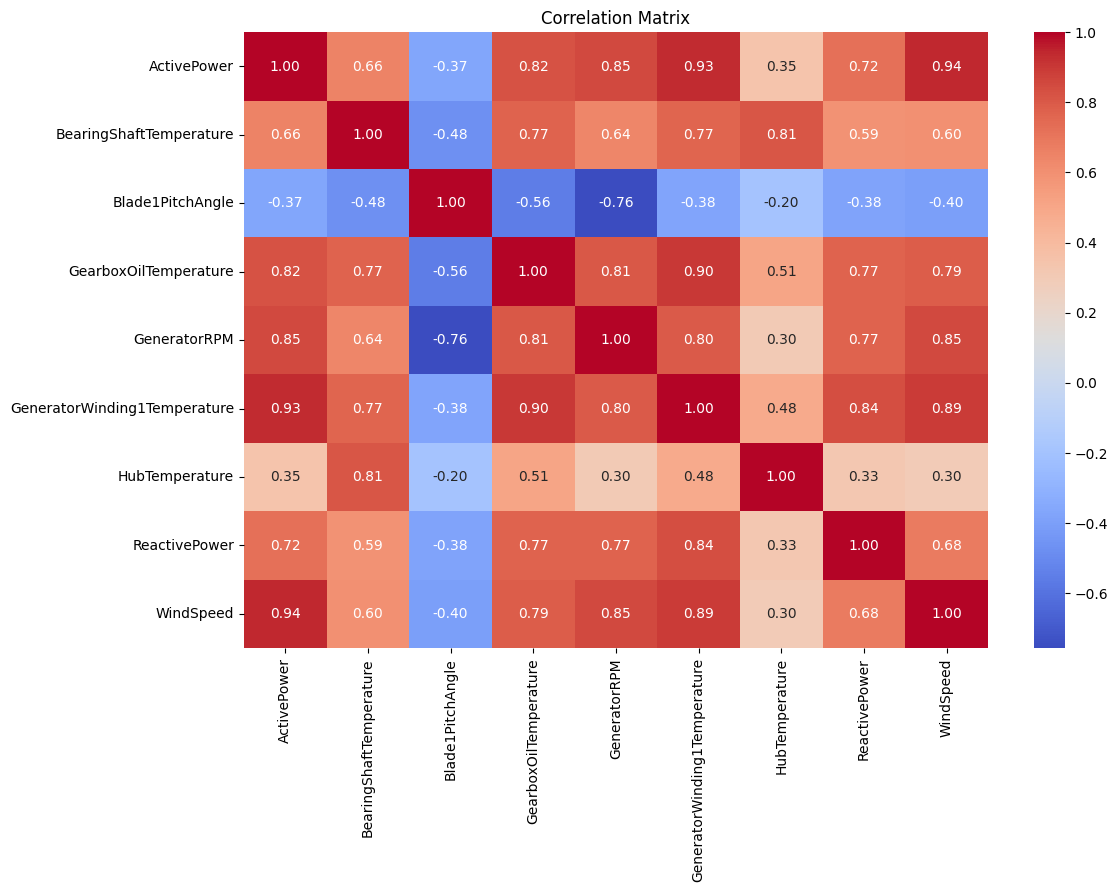

In [186]:
plt.figure(figsize=(12, 8))
correlation_matrix = df_cleaned.drop(columns=['Time']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We will perform visual and descriptive analyses on the selected variables to understand their distributions, identify any outliers, and assess the overall data quality. 
This analysis will guide us in selecting the most appropriate technique for filling in the missing values, ensuring that our approach is informed by the characteristics of the data.

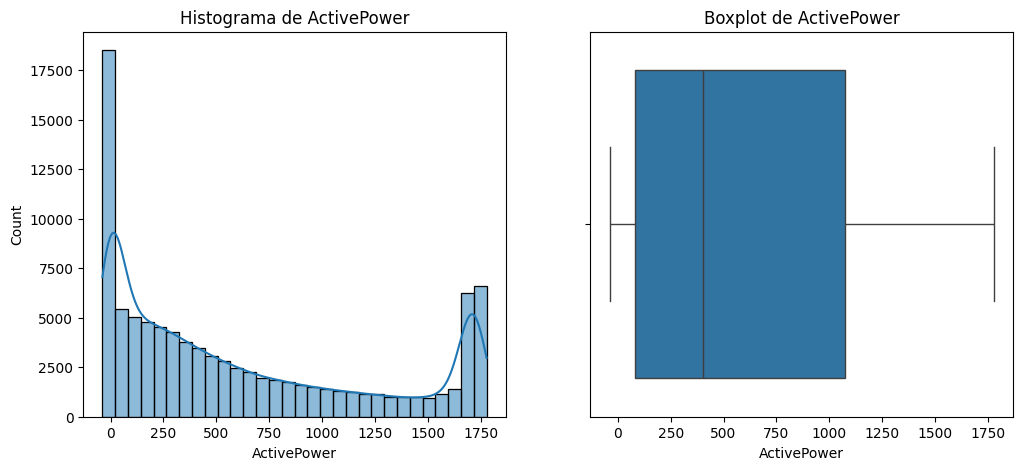

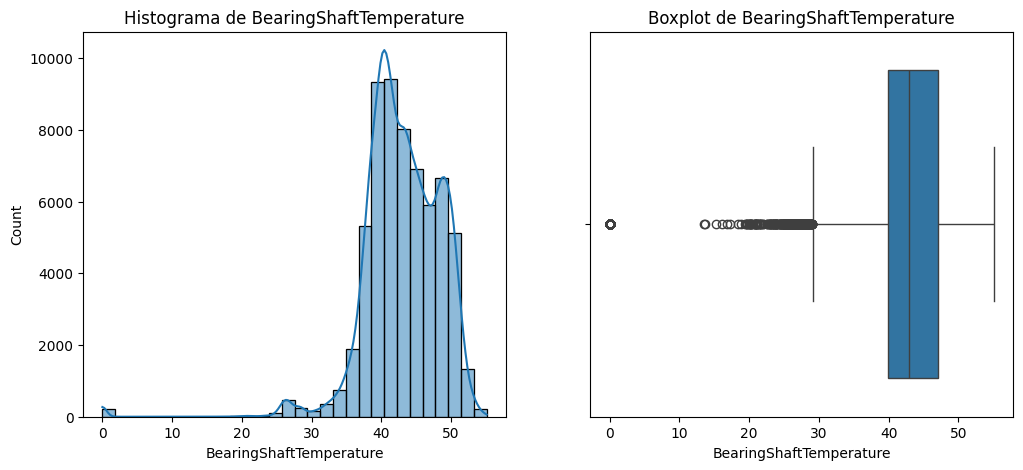

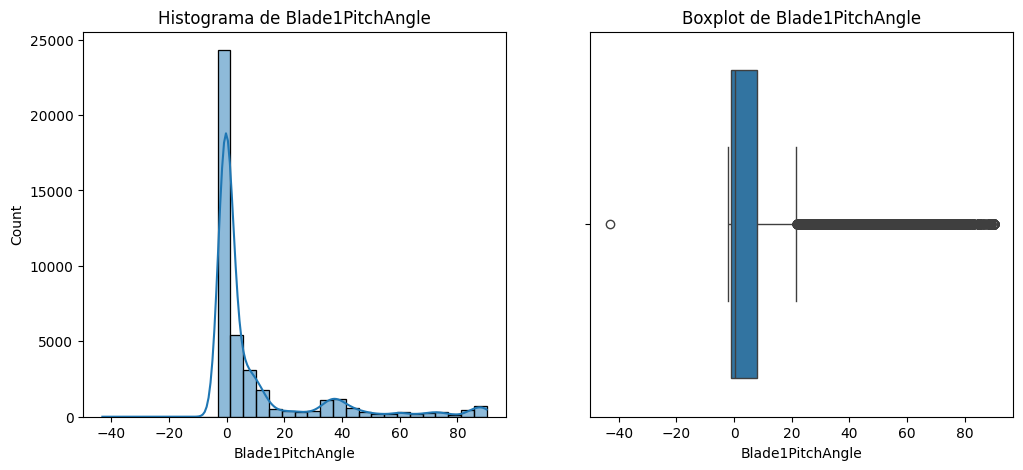

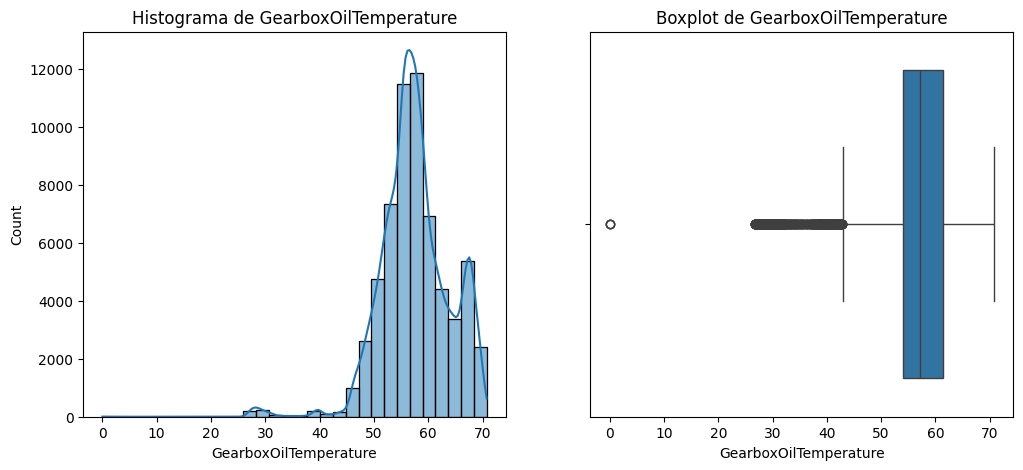

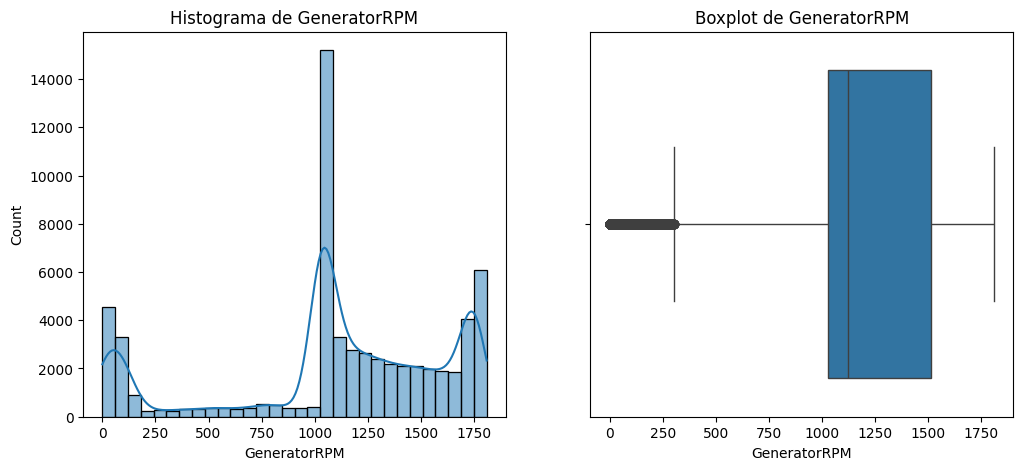

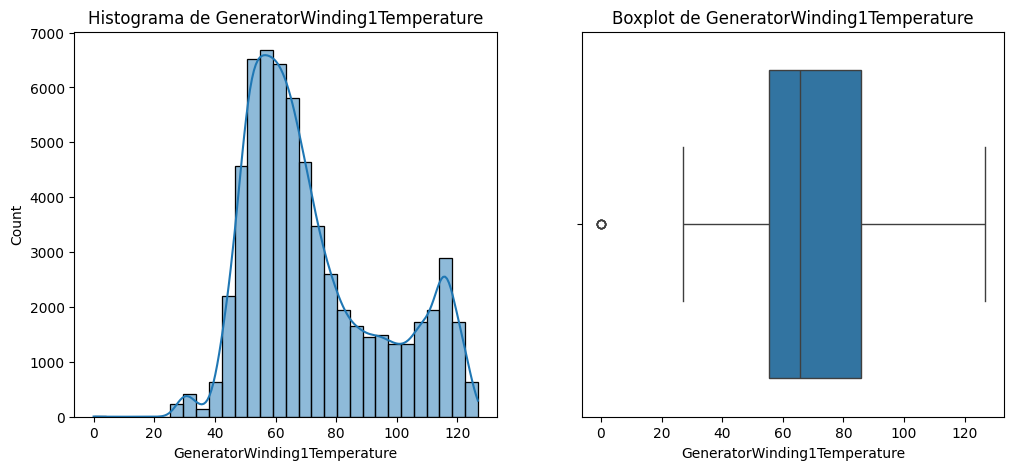

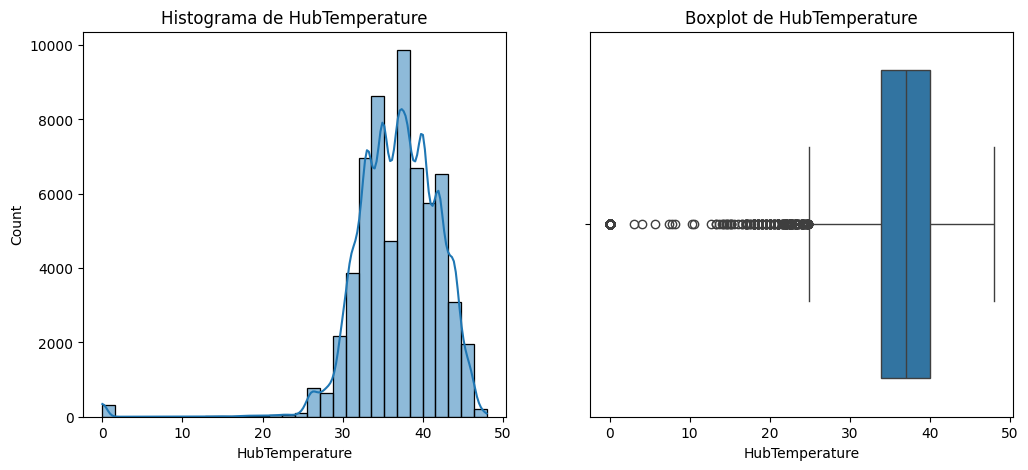

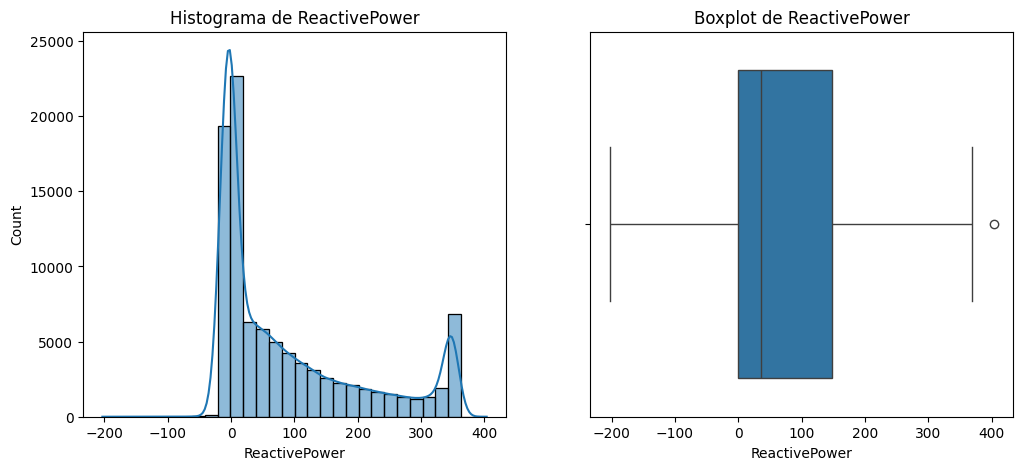

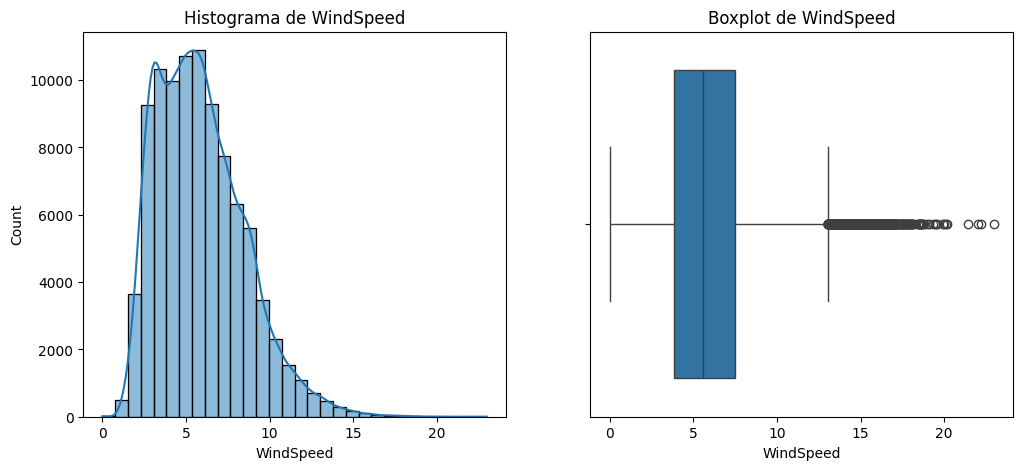

In [187]:
variables = ['ActivePower', 'BearingShaftTemperature', 'Blade1PitchAngle', 
             'GearboxOilTemperature', 'GeneratorRPM', 'GeneratorWinding1Temperature',
             'HubTemperature', 'ReactivePower', 'WindSpeed']

for var in variables:
    plt.figure(figsize=(12, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[var].dropna(), bins=30, kde=True)
    plt.title(f'Histograma de {var}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_cleaned[var])
    plt.title(f'Boxplot de {var}')

    plt.show()

In [188]:
stats = df_cleaned[variables].describe().T[['mean', '50%', 'std']]
stats.columns = ['Mean', 'Median', 'Std Dev']
print(stats)

                                     Mean       Median     Std Dev
ActivePower                    619.109805   402.654893  611.275373
BearingShaftTemperature         43.010189    42.910877    5.545312
Blade1PitchAngle                 9.749641     0.394399   20.644828
GearboxOilTemperature           57.561217    57.196089    6.323895
GeneratorRPM                  1102.026269  1124.860720  528.063946
GeneratorWinding1Temperature    72.460403    65.788800   22.627489
HubTemperature                  36.897978    37.003815    5.178711
ReactivePower                   88.133966    35.883659  116.596725
WindSpeed                        5.878960     5.557765    2.619084


In [189]:
for var in variables:
    Q1 = df_cleaned[var].quantile(0.25)
    Q3 = df_cleaned[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_cleaned[(df_cleaned[var] < lower_bound) | (df_cleaned[var] > upper_bound)]
    print(f'Outliers em {var}:')
    print(outliers)

Outliers em ActivePower:
Empty DataFrame
Columns: [Time, ActivePower, BearingShaftTemperature, Blade1PitchAngle, GearboxOilTemperature, GeneratorRPM, GeneratorWinding1Temperature, HubTemperature, ReactivePower, WindSpeed]
Index: []
Outliers em BearingShaftTemperature:
                             Time  ActivePower  BearingShaftTemperature  \
33158   2018-08-18 06:20:00+00:00     0.000000                 0.000000   
33207   2018-08-18 14:30:00+00:00  1691.912000                23.745117   
33211   2018-08-18 15:10:00+00:00  1709.615500                 0.000000   
33340   2018-08-19 12:40:00+00:00  1722.106275                24.032682   
33355   2018-08-19 15:10:00+00:00          NaN                 0.000000   
...                           ...          ...                      ...   
102390  2019-12-12 01:00:00+00:00   175.322860                27.399008   
102391  2019-12-12 01:10:00+00:00   154.224601                27.933973   
102392  2019-12-12 01:20:00+00:00   177.847757          

### Imputation Techniques for Variables

#### 1. ActivePower
- **Mean**: 619.11
- **Median**: 402.65
- **Outliers**: No significant outliers.
- **Recommended Technique**: Interpolation. Since there are no outliers, linear interpolation can be a good option, especially becouse the variable shows a clear temporal trend.

#### 2. BearingShaftTemperature
- **Mean**: 43.01
- **Median**: 42.91
- **Outliers**: There are some zero values and others that may be considered outliers.
- **Recommended Technique**: Median. The median is a good choice here as it is less sensitive to outliers, especially if there are zero values that do not represent the actual temperature.

#### 3. Blade1PitchAngle
- **Mean**: 9.75
- **Median**: 0.39
- **Outliers**: Presence of negative values and zeros.
- **Recommended Technique**: Median. Since the mean and median are very different, the median should be used for imputation. If there is a clear temporal pattern, interpolation may also be considered.

#### 4. GearboxOilTemperature
- **Mean**: 57.56
- **Median**: 57.20
- **Outliers**: Presence of outliers.
- **Recommended Technique**: Median. The median should be used due to the presence of outliers.

#### 5. GeneratorRPM
- **Mean**: 1102.03
- **Median**: 1124.86
- **Outliers**: Presence of very low values and zeros.
- **Recommended Technique**: Median. The median is more robust against outliers and should be the choice for imputation.

#### 6. GeneratorWinding1Temperature
- **Mean**: 72.46
- **Median**: 65.79
- **Outliers**: Presence of outliers.
- **Recommended Technique**: Median. The median should be used due to the presence of outliers.

#### 7. HubTemperature
- **Mean**: 36.90
- **Median**: 37.00
- **Outliers**: Presence of zeros.
- **Recommended Technique**: Median. The median is recommended, especially if there are zeros that do not represent the actual temperature.

#### 8. ReactivePower
- **Mean**: 88.13
- **Median**: 35.88
- **Outliers**: Presence of significant outliers.
- **Recommended Technique**: Median. The median should be used to avoid the influence of outliers.

#### 9. WindSpeed
- **Mean**: 5.88
- **Median**: 5.56
- **Outliers**: Presence of outliers.
- **Recommended Technique**: Median. The median is more robust against outliers and should be the choice for imputation.

#### Summary of Imputation Techniques

| Variable                       | Recommended Technique  |
|--------------------------------|------------------------|
| ActivePower                    | Interpolation          |
| BearingShaftTemperature        | Median                 |
| Blade1PitchAngle               | Median                 |
| GearboxOilTemperature          | Median                 |
| GeneratorRPM                   | Median                 |
| GeneratorWinding1Temperature   | Median                 |
| HubTemperature                 | Median                 |
| ReactivePower                  | Median                 |
| WindSpeed                      | Median                 |

In [190]:
# Imputation Techniques for Variables

# 1. ActivePower
# Fill missing values using linear interpolation since there are no significant outliers.
df_cleaned['ActivePower'].fillna(df_cleaned['ActivePower'].interpolate(method='linear'), inplace=True)

# 2. BearingShaftTemperature
# Fill missing values with the median as it is less sensitive to outliers.
df_cleaned['BearingShaftTemperature'].fillna(df_cleaned['BearingShaftTemperature'].median(), inplace=True)

# 3. Blade1PitchAngle
# Fill missing values with the median since the mean and median are very different.
# If there is a clear temporal pattern, interpolation could also be considered.
df_cleaned['Blade1PitchAngle'].fillna(df_cleaned['Blade1PitchAngle'].median(), inplace=True)

# 4. GearboxOilTemperature
# Fill missing values with the median due to the presence of outliers.
df_cleaned['GearboxOilTemperature'].fillna(df_cleaned['GearboxOilTemperature'].median(), inplace=True)

# 5. GeneratorRPM
# Fill missing values with the median as it is more robust against outliers.
df_cleaned['GeneratorRPM'].fillna(df_cleaned['GeneratorRPM'].median(), inplace=True)

# 6. GeneratorWinding1Temperature
# Fill missing values with the median due to the presence of outliers.
df_cleaned['GeneratorWinding1Temperature'].fillna(df_cleaned['GeneratorWinding1Temperature'].median(), inplace=True)

# 7. HubTemperature
# Fill missing values with the median, especially if there are zeros that do not represent actual temperature.
df_cleaned['HubTemperature'].fillna(df_cleaned['HubTemperature'].median(), inplace=True)

# 8. ReactivePower
# Fill missing values with the median to avoid the influence of significant outliers.
df_cleaned['ReactivePower'].fillna(df_cleaned['ReactivePower'].median(), inplace=True)

# 9. WindSpeed
# Fill missing values with the median as it is more robust against outliers.
df_cleaned['WindSpeed'].fillna(df_cleaned['WindSpeed'].median(), inplace=True)

# Check again the missing values
missing_values = df_cleaned.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 Time                            0
ActivePower                     0
BearingShaftTemperature         0
Blade1PitchAngle                0
GearboxOilTemperature           0
GeneratorRPM                    0
GeneratorWinding1Temperature    0
HubTemperature                  0
ReactivePower                   0
WindSpeed                       0
dtype: int64


After conducting a thorough analysis and visualization of our dataset, we have gained valuable insights into the relationships and patterns present within the data. We addressed missing values, identified and removed highly correlated and low-correlation variables, and ensured the overall quality of our dataset.

With these preparations complete, we are now ready to proceed to the next phase of our project: the modeling process. This groundwork will enhance our ability to build effective predictive models and derive meaningful conclusions from our analysis.

## Modeling <a name="modeling"></a>
In this section, we will build machine learning models to predict students' academic performance based on their alcohol consumption and other features. We will choose appropriate algorithms and fit them to our training data.

In [191]:
# Checking for Stationarity

# Augmented Dickey-Fuller (ADF) Test
result = adfuller(df_cleaned['ActivePower'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

#KPSS Test
kpss_statistic, p_value, _, critical_values = kpss(df_cleaned['ActivePower'])
print('KPSS Statistic:', kpss_statistic)
print('p-value:', p_value)
print('Critical Values:', critical_values)



ADF Statistic: -17.676695931658458
p-value: 3.6239019820187515e-30
KPSS Statistic: 1.3741621620554305
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


ADF Statistic (Differenced): -52.68325737759506
p-value (Differenced): 0.0
KPSS Statistic (Differenced): 0.0042131672312235
p-value (Differenced): 0.1


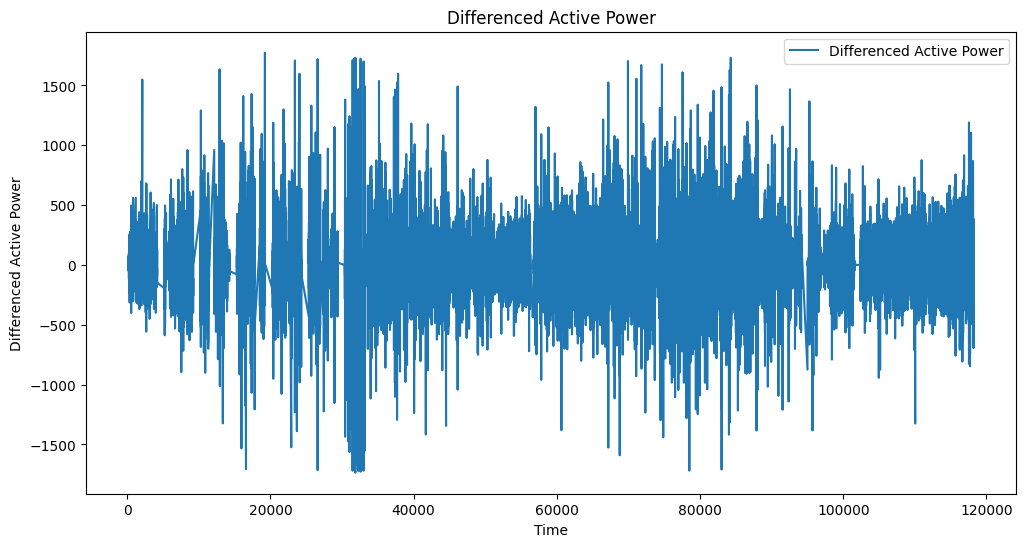

In [192]:
# Applying differentiation to the 'ActivePower' column

df_cleaned['active_power_diff'] = df_cleaned['ActivePower'].diff().dropna()

# Performing the ADF (Augmented Dickey-Fuller) test on the differenced series
# The ADF test checks for stationarity in the time series data.
result_adf = adfuller(df_cleaned['active_power_diff'].dropna())

# Printing the ADF statistic and p-value for the differenced series

print('ADF Statistic (Differenced):', result_adf[0])
print('p-value (Differenced):', result_adf[1])

# Performing the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test on the differenced series
# The KPSS test also checks for stationarity but has the null hypothesis that the series is stationary.
kpss_statistic, p_value, _, critical_values = kpss(df_cleaned['active_power_diff'].dropna())

# Printing the KPSS statistic and p-value for the differenced series

print('KPSS Statistic (Differenced):', kpss_statistic)
print('p-value (Differenced):', p_value)

plt.figure(figsize=(12, 6))
# Plotting the differenced active power data
plt.plot(df_cleaned['active_power_diff'], label='Differenced Active Power')
plt.title('Differenced Active Power')
plt.xlabel('Time')
plt.ylabel('Differenced Active Power')
plt.legend()
plt.show()

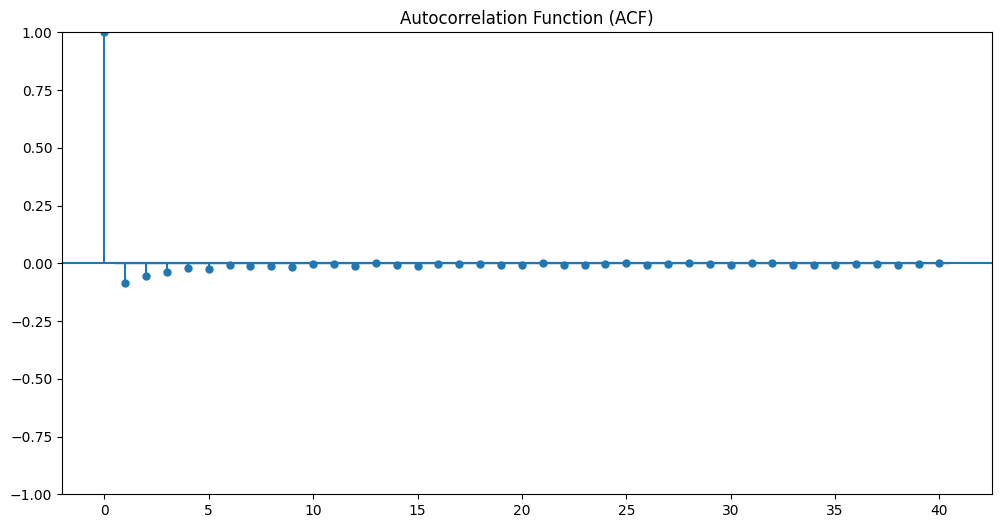

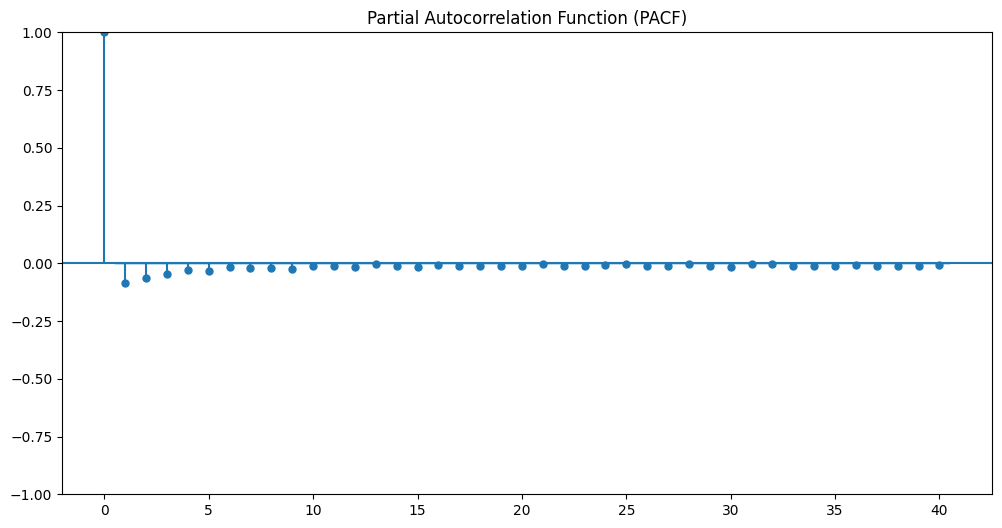

In [199]:
#ACF and PACF Plots
plt.figure(figsize=(12, 6))
plot_acf(df_cleaned['active_power_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_cleaned['active_power_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Outliers identified by Z-score:
Empty DataFrame
Columns: [Time, ActivePower, BearingShaftTemperature, Blade1PitchAngle, GearboxOilTemperature, GeneratorRPM, GeneratorWinding1Temperature, HubTemperature, ReactivePower, WindSpeed, active_power_diff]
Index: []
Outliers identified by IQR:
Empty DataFrame
Columns: [Time, ActivePower, BearingShaftTemperature, Blade1PitchAngle, GearboxOilTemperature, GeneratorRPM, GeneratorWinding1Temperature, HubTemperature, ReactivePower, WindSpeed, active_power_diff]
Index: []


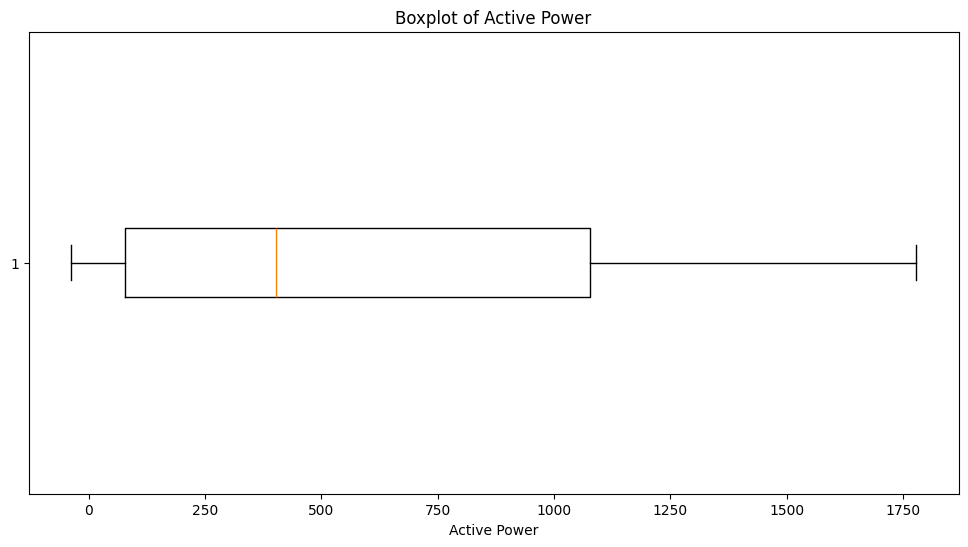

In [193]:
# Outlier Detection
# Z-score
import numpy as np

# Calculate the Z-score
z_scores = np.abs((df_cleaned['ActivePower'] - df_cleaned['ActivePower'].mean()) / df_cleaned['ActivePower'].std())
outliers_z = df_cleaned[z_scores > 3]
print("Outliers identified by Z-score:")
print(outliers_z)
IQR
Q1 = df_cleaned['ActivePower'].quantile(0.25)
Q3 = df_cleaned['ActivePower'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_iqr = df_cleaned[(df_cleaned['ActivePower'] < (Q1 - 1.5 * IQR)) | (df_cleaned['ActivePower'] > (Q3 + 1.5 * IQR))]
print("Outliers identified by IQR:")
print(outliers_iqr)

# Boxplot to visualize outliers
plt.figure(figsize=(12, 6))
plt.boxplot(df_cleaned['ActivePower'], vert=False)
plt.title('Boxplot of Active Power')
plt.xlabel('Active Power')
plt.show()

## Model Evaluation <a name="model-evaluation"></a>
After building our models, we will evaluate their performance using various metrics. We will compare the predictions against the actual outcomes to determine how well our models are performing.

## Conclusion and Next Steps <a name="conclusion-and-next-steps"></a>
In the final section, we will summarize our findings from the analysis and discuss potential next steps. This may include further analysis, model improvements, or recommendations for educators based on the insights gained from the data.